# Prediction Model using TuriCreate in Julia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Fetch-Data-(SFrame)-from-Uber-CSV" data-toc-modified-id="Fetch-Data-(SFrame)-from-Uber-CSV-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fetch Data (SFrame) from Uber CSV</a></span></li><li><span><a href="#Split-Data" data-toc-modified-id="Split-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Split Data</a></span></li><li><span><a href="#Evaluate-the-Model" data-toc-modified-id="Evaluate-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate the Model</a></span></li><li><span><a href="#Save-/-Export-the-Model" data-toc-modified-id="Save-/-Export-the-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save / Export the Model</a></span></li><li><span><a href="#Make-predictions" data-toc-modified-id="Make-predictions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make predictions</a></span><ul class="toc-item"><li><span><a href="#Explore-SFrame" data-toc-modified-id="Explore-SFrame-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Explore SFrame</a></span></li></ul></li></ul></div>

## Set Up

In [1]:
symbol_to_predict = "DJIA" # - there is a bug
# symbol_to_predict = "AAPL"
#symbol_to_predict = "VIX"
# symbol_to_predict = "NIO"
#symbol_to_predict = "NVDA"

features_to_analyze = 
[
 
"GSPC_Quantized"
,"GSPC_Avg005"
,"GSPC_Avg010"
,"GSPC_Avg030"
,"GSPC_Avg060"
,"GSPC_Avg090"
,"GSPC_Avg120"
,"GSPC_Avg180"
 
,"BTC_USD_Quantized"
,"BTC_USD_Avg005"
,"BTC_USD_Avg010"
,"BTC_USD_Avg030"
,"BTC_USD_Avg060"
,"BTC_USD_Avg090"
,"BTC_USD_Avg120"
,"BTC_USD_Avg180"
 
,"DALLAS_FED_MFC_Quantized"
,"DALLAS_FED_MFC_Avg005"
,"DALLAS_FED_MFC_Avg010"
,"DALLAS_FED_MFC_Avg030"
,"DALLAS_FED_MFC_Avg060"
,"DALLAS_FED_MFC_Avg090"
,"DALLAS_FED_MFC_Avg120"
,"DALLAS_FED_MFC_Avg180"
 
,"GOLD_Quantized"
,"GOLD_Avg005"
,"GOLD_Avg010"
,"GOLD_Avg030"
,"GOLD_Avg060"
,"GOLD_Avg090"
,"GOLD_Avg120"
,"GOLD_Avg180"
 
,"GELYF_Quantized"
,"GELYF_Avg005"
,"GELYF_Avg010"
,"GELYF_Avg030"
,"GELYF_Avg060"
,"GELYF_Avg090"
,"GELYF_Avg120"
,"GELYF_Avg180"
 
,"US_PEND_HOME_SALE_M_Quantized"
,"US_PEND_HOME_SALE_M_Avg005"
,"US_PEND_HOME_SALE_M_Avg010"
,"US_PEND_HOME_SALE_M_Avg030"
,"US_PEND_HOME_SALE_M_Avg060"
,"US_PEND_HOME_SALE_M_Avg090"
,"US_PEND_HOME_SALE_M_Avg120"
,"US_PEND_HOME_SALE_M_Avg180"
 
,"TNX_Quantized"
,"TNX_Avg005"
,"TNX_Avg010"
,"TNX_Avg030"
,"TNX_Avg060"
,"TNX_Avg090"
,"TNX_Avg120"
,"TNX_Avg180"
 
,"TSLA_Quantized"
,"TSLA_Avg005"
,"TSLA_Avg010"
,"TSLA_Avg030"
,"TSLA_Avg060"
,"TSLA_Avg090"
,"TSLA_Avg120"
,"TSLA_Avg180"
 
,"US_BUILD_PERM_Quantized"
,"US_BUILD_PERM_Avg005"
,"US_BUILD_PERM_Avg010"
,"US_BUILD_PERM_Avg030"
,"US_BUILD_PERM_Avg060"
,"US_BUILD_PERM_Avg090"
,"US_BUILD_PERM_Avg120"
,"US_BUILD_PERM_Avg180"
 
,"BYDDF_Quantized"
,"BYDDF_Avg005"
,"BYDDF_Avg010"
,"BYDDF_Avg030"
,"BYDDF_Avg060"
,"BYDDF_Avg090"
,"BYDDF_Avg120"
,"BYDDF_Avg180"
 
,"US_INDS_PROD_M_Quantized"
,"US_INDS_PROD_M_Avg005"
,"US_INDS_PROD_M_Avg010"
,"US_INDS_PROD_M_Avg030"
,"US_INDS_PROD_M_Avg060"
,"US_INDS_PROD_M_Avg090"
,"US_INDS_PROD_M_Avg120"
,"US_INDS_PROD_M_Avg180"
 
,"US_ISM_MFC_EMPL_Quantized"
,"US_ISM_MFC_EMPL_Avg005"
,"US_ISM_MFC_EMPL_Avg010"
,"US_ISM_MFC_EMPL_Avg030"
,"US_ISM_MFC_EMPL_Avg060"
,"US_ISM_MFC_EMPL_Avg090"
,"US_ISM_MFC_EMPL_Avg120"
,"US_ISM_MFC_EMPL_Avg180"
 
,"US_INIT_JOB_CLAIM_Quantized"
,"US_INIT_JOB_CLAIM_Avg005"
,"US_INIT_JOB_CLAIM_Avg010"
,"US_INIT_JOB_CLAIM_Avg030"
,"US_INIT_JOB_CLAIM_Avg060"
,"US_INIT_JOB_CLAIM_Avg090"
,"US_INIT_JOB_CLAIM_Avg120"
,"US_INIT_JOB_CLAIM_Avg180"
 
,"US_UNEMPLOY_RATE_Quantized"
,"US_UNEMPLOY_RATE_Avg005"
,"US_UNEMPLOY_RATE_Avg010"
,"US_UNEMPLOY_RATE_Avg030"
,"US_UNEMPLOY_RATE_Avg060"
,"US_UNEMPLOY_RATE_Avg090"
,"US_UNEMPLOY_RATE_Avg120"
,"US_UNEMPLOY_RATE_Avg180"
 
,"NVDA_Quantized"
,"NVDA_Avg005"
,"NVDA_Avg010"
,"NVDA_Avg030"
,"NVDA_Avg060"
,"NVDA_Avg090"
,"NVDA_Avg120"
,"NVDA_Avg180"
 
,"NRMGX_Quantized"
,"NRMGX_Avg005"
,"NRMGX_Avg010"
,"NRMGX_Avg030"
,"NRMGX_Avg060"
,"NRMGX_Avg090"
,"NRMGX_Avg120"
,"NRMGX_Avg180"
 
,"US_HOUS_STRS_M_Quantized"
,"US_HOUS_STRS_M_Avg005"
,"US_HOUS_STRS_M_Avg010"
,"US_HOUS_STRS_M_Avg030"
,"US_HOUS_STRS_M_Avg060"
,"US_HOUS_STRS_M_Avg090"
,"US_HOUS_STRS_M_Avg120"
,"US_HOUS_STRS_M_Avg180"
 
,"HD_Quantized"
,"HD_Avg005"
,"HD_Avg010"
,"HD_Avg030"
,"HD_Avg060"
,"HD_Avg090"
,"HD_Avg120"
,"HD_Avg180"
 
,"US_GDP_Q_Quantized"
,"US_GDP_Q_Avg005"
,"US_GDP_Q_Avg010"
,"US_GDP_Q_Avg030"
,"US_GDP_Q_Avg060"
,"US_GDP_Q_Avg090"
,"US_GDP_Q_Avg120"
,"US_GDP_Q_Avg180"
 
,"VIX_Quantized"
,"VIX_Avg005"
,"VIX_Avg010"
,"VIX_Avg030"
,"VIX_Avg060"
,"VIX_Avg090"
,"VIX_Avg120"
,"VIX_Avg180"
 
,"TPLGX_Quantized"
,"TPLGX_Avg005"
,"TPLGX_Avg010"
,"TPLGX_Avg030"
,"TPLGX_Avg060"
,"TPLGX_Avg090"
,"TPLGX_Avg120"
,"TPLGX_Avg180"
 
,"US_ISM_MFC_PMI_Quantized"
,"US_ISM_MFC_PMI_Avg005"
,"US_ISM_MFC_PMI_Avg010"
,"US_ISM_MFC_PMI_Avg030"
,"US_ISM_MFC_PMI_Avg060"
,"US_ISM_MFC_PMI_Avg090"
,"US_ISM_MFC_PMI_Avg120"
,"US_ISM_MFC_PMI_Avg180"
 
,"VINIX_Quantized"
,"VINIX_Avg005"
,"VINIX_Avg010"
,"VINIX_Avg030"
,"VINIX_Avg060"
,"VINIX_Avg090"
,"VINIX_Avg120"
,"VINIX_Avg180"
 
,"VBTLX_Quantized"
,"VBTLX_Avg005"
,"VBTLX_Avg010"
,"VBTLX_Avg030"
,"VBTLX_Avg060"
,"VBTLX_Avg090"
,"VBTLX_Avg120"
,"VBTLX_Avg180"
 
,"RERGX_Quantized"
,"RERGX_Avg005"
,"RERGX_Avg010"
,"RERGX_Avg030"
,"RERGX_Avg060"
,"RERGX_Avg090"
,"RERGX_Avg120"
,"RERGX_Avg180"
 
,"CRSP_Quantized"
,"CRSP_Avg005"
,"CRSP_Avg010"
,"CRSP_Avg030"
,"CRSP_Avg060"
,"CRSP_Avg090"
,"CRSP_Avg120"
,"CRSP_Avg180"
 
,"BABA_Quantized"
,"BABA_Avg005"
,"BABA_Avg010"
,"BABA_Avg030"
,"BABA_Avg060"
,"BABA_Avg090"
,"BABA_Avg120"
,"BABA_Avg180"
 
,"DJIA_Quantized"
,"DJIA_Avg005"
,"DJIA_Avg010"
,"DJIA_Avg030"
,"DJIA_Avg060"
,"DJIA_Avg090"
,"DJIA_Avg120"
,"DJIA_Avg180"
 
,"AAPL_Quantized"
,"AAPL_Avg005"
,"AAPL_Avg010"
,"AAPL_Avg030"
,"AAPL_Avg060"
,"AAPL_Avg090"
,"AAPL_Avg120"
,"AAPL_Avg180"
 
    
]

println()

In [2]:
## uncomment for the first run
# import Pkg
# Pkg.add("PyCall")
# Pkg.add("Conda")
# ENV["PYTHON"] = "/opt/anaconda3/envs/turi/bin/python"
# /opt/anaconda3/envs/turi/lib/python3.6/site-packages/
# Pkg.build("PyCall")

include("../Julia/functions.jl") 
data_path="../DATA/processed/uber_training.csv"
column_to_predict = symbol_to_predict * "_Original"

"DJIA_Original"

## Fetch Data (SFrame) from Uber CSV

In [3]:
using PyCall
tc = pyimport("turicreate")
data = tc.SFrame(data_path)
println()

Finished parsing file /Users/uki/REPOS/MarketIndicators.jl/src/DATA/processed/uber_training.csv
Parsing completed. Parsed 100 lines in 0.036668 secs.
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,floa

## Split Data

In [4]:
# Make a train-test split
train_data, test_data = data.random_split(0.8)

println( size(train_data) )
println( size(test_data)  )

(362,)
(90,)


In [5]:
model = tc.regression.create( 
    train_data, 
    target = column_to_predict, 
    features = features_to_analyze, 
    validation_set="auto", 
    verbose=true
)

Automatically generating validation set from 5% of the data.
Linear regression:
--------------------------------------------------------
Number of examples          : 345
Number of features          : 232
Number of unpacked features : 232
Number of coefficients    : 233
Starting Newton Method
--------------------------------------------------------
+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+
| Iteration | Passes   | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |
+-----------+----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+
| 1         | 2        | 1.035101     | 104.274802         | 59.752487            | 28.463671                       | 31.466115                         |
+-----------+----------+---------

PyObject Class                          : LinearRegression

Schema
------
Number of coefficients         : 233
Number of examples             : 345
Number of feature columns      : 232
Number of unpacked features    : 232

Hyperparameters
---------------
L1 penalty                     : 0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 1
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 1.0471

Settings
--------
Residual sum of squares        : 279512.2895
Training RMSE                  : 28.4637

Highest Positive Coefficients
-----------------------------
(intercept)                    : 16768.258
DJIA_Quantized                 : 68.32
GSPC_Quantized                 : 37.3177
GELYF_Avg090                   : 10.1974
VINIX_Quantized                : 8.7505

Lowest Negative Coefficients
----------------------------
BTC_USD_Avg180             

## Evaluate the Model

In [6]:
#TODO: write this in a loop to select the best model
# Evaluate the model and save the results into a dictionary
results = model.evaluate( test_data ) #test_data[0:2531]
results

Dict{Any,Any} with 2 entries:
  "rmse"      => 43.2746
  "max_error" => 128.488

In [7]:
rmse = results["rmse"]
rmse = round(rmse, digits=2)

max_error = results["max_error"]
max_error = round(max_error, digits=2)

println( "max_error: ", max_error, ", rmse: ", rmse )
# max_error: 1069.27, rmse: 184.6
# max_error: 65.35, rmse: 32.6            predict: ^DJIA added: US_INIT_JOBLESS
# max_error: 1875.39, rmse: 443.59        predict: ^DJIA commented out: "DJIA_Quantized"
# max_error: 1339.76, rmse: 373.94        predict: ^DJIA commented out: "DJIA_Quantized"
# max_error: 916.19, rmse: 231.24       predict: ^DJIA with "DJIA_Avg005"

max_error: 128.49, rmse: 43.27


## Save / Export the Model

In [8]:
# Export to Core ML
model.export_coreml("../DATA/models/^DJI.mlmodel")

## Make predictions 

In [9]:
data_path="../DATA/processed/uber_prediction.csv"
data_predictions = tc.SFrame(data_path)

## Save predictions to an SArray
predictions = model.predict(data_predictions)
#get(predictions, 1)

println()

Finished parsing file /Users/uki/REPOS/MarketIndicators.jl/src/DATA/processed/uber_prediction.csv
Parsing completed. Parsed 95 lines in 0.046717 secs.
------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,flo

### Explore SFrame

In [10]:
record_count = size(data_predictions)[1]
row = get(data_predictions, record_count-1)

feature_number = row.count
day = row["Rata_Die"]
date = row["Date"] # "2020-10-20"
original = row["DJIA_Original"]

println( "record_count data ", record_count )
println( "record_count predictions ", size(predictions)[1] )

println( "feature_number ", feature_number )
println( "Rata Die ", day )
println( "date ", date )
println( "original ", original )

record_count data 95
record_count predictions 95
feature_number 263
Rata Die 737774
date 2020-12-15
original 30071.130859


In [11]:
using Dates
today_rata = Dates.datetime2rata( today() )

## Determine dataset size

initio = 1                                              # latin: start
finem  = size(predictions)[1] -1                        # latin: end
gradus = convert(Int64, round( finem/20, digits=0)  )   # latin: step

println("preditions set size: ", finem, ", step ", gradus)


## Declare variables
x_axis_dates      = Vector{Date}() # results in Array{Date,1}
y_axis_original   = Vector{Float64}()
y_axis_predicted  = Vector{Float64}()

println(symbol_to_predict, " ", finem, " ", typeof(x_axis_dates))

today_id  = 50 # not set yet

## step thru each prediction
for id in initio:finem
    row = get(data_predictions, id) # get a dictionary of data from the SFrame
    
    date_string = row["Date"] # e.g. "2020-10-20"
    date = Date(date_string) # 2020-09-07 Date
    if date == today()
        today_id = id
    end 
    #date = Dates.format(date, "u.d,yy" )
    #println("date ", date, " ", typeof(date))
    push!(x_axis_dates, date)
    
    predicted = get(predictions, id) # Float64
    predicted = round(predicted, digits=0)
    #println("predicted ", predicted, " ", typeof(predicted))
    append!(y_axis_predicted, predicted)
    
    
    original = row[ column_to_predict ]
    original = round(original, digits=0) # Float64
    #println("original ", original, " ", typeof(original)) 
    append!(y_axis_original, original)
end

## Format Dates for plotting
include("../Julia/function_format_dates.jl")
x_axis_dates = format_dates(x_axis_dates, "u. d, yy")



t = today()# Date
t = format_dates([t], "u. d, yyyy") # Array{String,1}
t = t[1] # String
println("t ", t, " ", typeof(t))

println()

preditions set size: 94, step 5
DJIA 94 Array{Date,1}
t Dec. 11, 2020 String



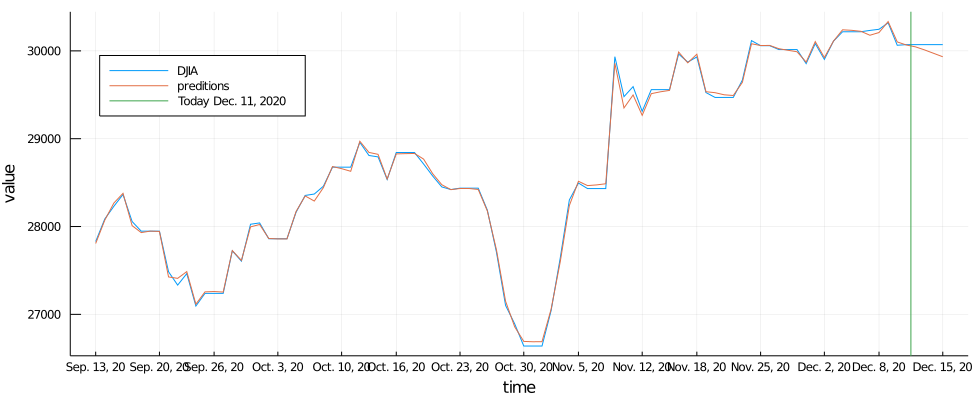

In [12]:
using Plots

#dates = format_dates( df[rows,2] , "m/d/yy")

gr()
plot(    x_axis_dates,
        [  y_axis_original y_axis_predicted 
        ], # y-axis
    label    = 
        [ symbol_to_predict "preditions"  "" ],
    legend   =:topleft, 
              # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "value",
    size     = (980, 400), # width, height
    layout = (1, 1), # number of graphs: vertically, horizontally
    )
## Add veritical today line
plot!([today_id], seriestype="vline", label=[ "Today "*t "" ],)


In [13]:
savefig("../images/predictions_" * symbol_to_predict * ".png")

In [16]:
## print prediction comparisons
println(symbol_to_predict, " ", today())

file_path = "../DATA/" * symbol_to_predict * "_predictions.csv"
open( file_path, "a") do file_handle # append
    
    for id in finem-10:finem
        if id < today_id + 3
            row = get(data_predictions, id) # get a dictionary of data from the SFrame
            date_string = row["Date"] # e.g. "2020-10-20"

            a = y_axis_predicted[id]
            b = y_axis_original[id]
            d = round(b-a, digits=3)
            date = convert(String, Dates.format( Date(date_string), "e, yyyy-mm-dd" ) )
            if id <= today_id
                println( date, "\t predicted ", a , "\t, but actual value was \t", b , "\t difference is ",  d  ) # di
            else
                println( date, "\t predicted ", a  ) # 

                txt_to_save =  
                    convert(String, Dates.format( today(), "yyyy-mm-dd" ) ) *","* 
                    convert(String, symbol_to_predict) *","* 
                    date_string *","* 
                    string(a) * "\n"
                
                write(file_handle, txt_to_save )
                
            end # if
        end #if 
    end # for
end # open file

DJIA 2020-12-11
Sat, 2020-12-05	 predicted 30234.0	, but actual value was 	30218.0	 difference is -16.0
Sun, 2020-12-06	 predicted 30223.0	, but actual value was 	30218.0	 difference is -5.0
Mon, 2020-12-07	 predicted 30178.0	, but actual value was 	30233.0	 difference is 55.0
Tue, 2020-12-08	 predicted 30209.0	, but actual value was 	30246.0	 difference is 37.0
Wed, 2020-12-09	 predicted 30334.0	, but actual value was 	30320.0	 difference is -14.0
Thu, 2020-12-10	 predicted 30102.0	, but actual value was 	30064.0	 difference is -38.0
Fri, 2020-12-11	 predicted 30067.0	, but actual value was 	30071.0	 difference is 4.0
Sat, 2020-12-12	 predicted 30046.0
Sun, 2020-12-13	 predicted 30011.0
